In [470]:
import pandas as pd #Dataframe manipulation library
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import random
import math #Math functions
import time
from matplotlib import style
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
%matplotlib inline 

In [471]:
###Import the data
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [472]:
cols = confirmed_df.keys()

In [473]:
###Get all the dates for the outbreak
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [474]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 
recovery_rate = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

In [475]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [476]:
###Future forecast
days_in_future = 4
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)

In [477]:
###Convert integer into datetime for better visualization
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
adjusted_dates = future_forcast_dates[:-4]

In [478]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.1, shuffle=False) 

In [479]:
kernel = ['linear', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.4s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [480]:
svm_search.best_params_

{'shrinking': True, 'kernel': 'linear', 'gamma': 0.1, 'epsilon': 1, 'C': 10}

In [481]:
svm_confirmed = svm_search.best_estimator_
svm_predc = svm_confirmed.predict(future_forcast)

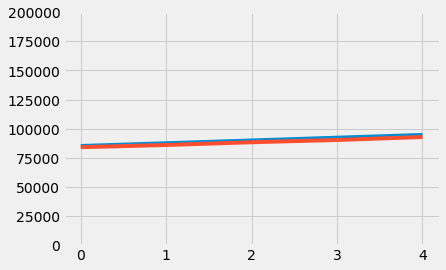

In [482]:
# check against testing data
svm_test_predc = svm_confirmed.predict(X_test_confirmed)
style.use('fivethirtyeight')
plt.ylim([0, 2e5])
plt.plot(svm_test_predc)
plt.plot(y_test_confirmed)

In [483]:
ensemble_grid =  {'n_estimators': [(i+1)*10 for i in range(20)],
                 'criterion': ['mse', 'mae'],
                 'bootstrap': [True, False],
                 
                 }

ensemble = RandomForestRegressor()
ensemble_search = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
ensemble_search.fit(X_train_confirmed, y_train_confirmed.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.9s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [484]:
ensemble_search.best_params_

{'n_estimators': 120, 'criterion': 'mse', 'bootstrap': False}

In [485]:
ensemble_confirmed = ensemble_search.best_estimator_
ensemble_predc = ensemble_confirmed.predict(future_forcast)

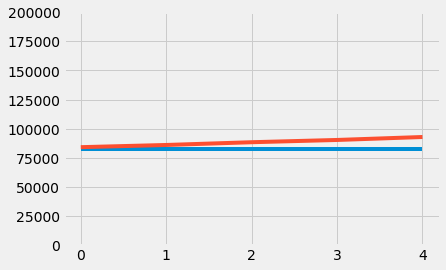

In [486]:
# check against testing data
ensemble_test_pred = ensemble_confirmed.predict(X_test_confirmed)
plt.ylim([0, 2e5])
plt.plot(ensemble_test_pred)
plt.plot(y_test_confirmed)

In [487]:
linear_model = LinearRegression(fit_intercept=False, normalize=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_predc = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 6845.931210662724
MSE: 47030229.258331336


In [488]:
linear_model.coef_

array([[2440.45464643]])

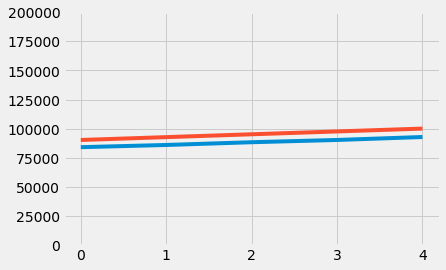

In [489]:
# check against testing data
plt.ylim([0, 2e5])
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

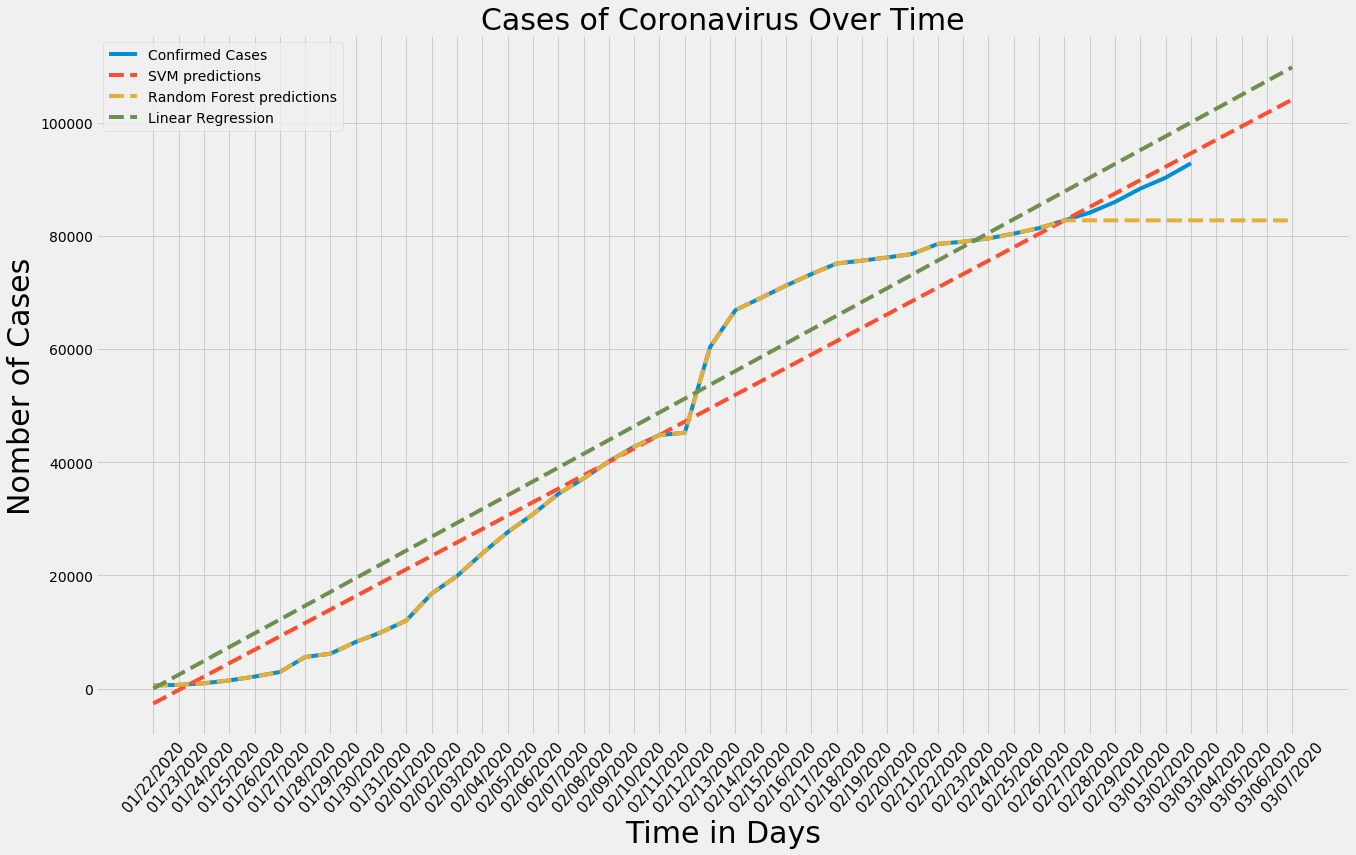

In [490]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, svm_predc, linestyle='dashed')
plt.plot(future_forcast_dates, ensemble_predc, linestyle='dashed')
plt.plot(future_forcast_dates, linear_predc, linestyle='dashed')
plt.title('Cases of Coronavirus Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Nomber of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions', 'Random Forest predictions', 'Linear Regression'])
plt.xticks(rotation=50, size=15)
plt.show()

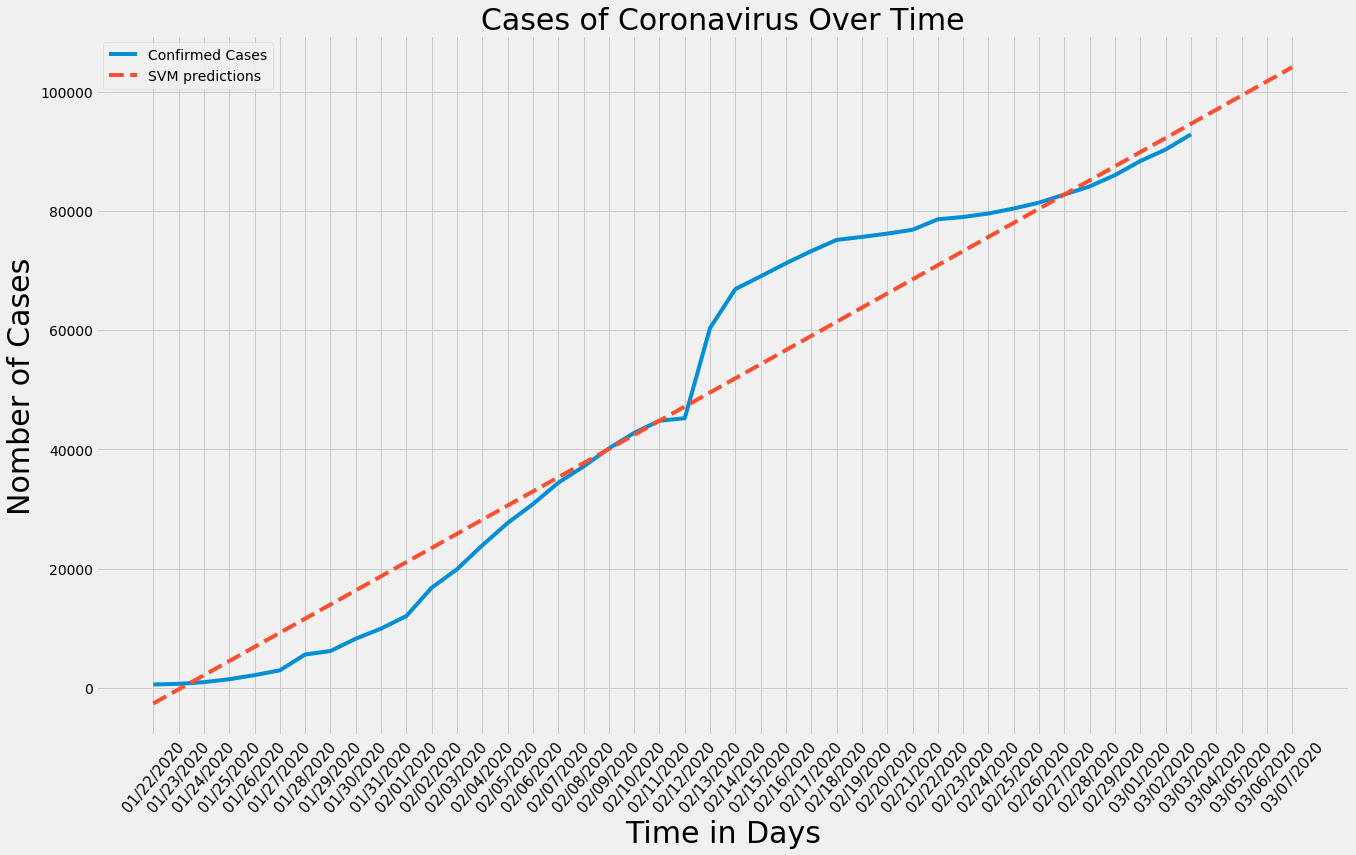

In [491]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, svm_predc, linestyle='dashed')
plt.title('Cases of Coronavirus Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Nomber of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

In [492]:
# predictions using svm, which is the best model out of all three 
Cases_Predict = pd.DataFrame((future_forcast_dates[-4:], svm_predc[-4:]))
Cases_Predict.columns = Cases_Predict.iloc[0]
Cases_Predict = Cases_Predict.drop([0])
Cases_Predict.rename({1: 'Cases'})

,03/04/2020,03/05/2020,03/06/2020,03/07/2020
Cases,96989.4,99361.4,101734,104106


In [493]:
cols = deaths_df.keys()

In [494]:
###Get all the dates for the outbreak
deaths = deaths_df.loc[:, cols[4]:cols[-1]]

In [495]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)

In [496]:
###Future forecast
days_in_future = 4
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)

In [497]:
X_train_deaths, X_test_deaths, y_train_deaths, y_test_deaths = train_test_split(days_since_1_22, total_deaths, test_size=0.1, shuffle=False) 

In [498]:
kernel = ['linear', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_deaths, y_train_deaths.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.0s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [499]:
svm_search.best_params_

{'shrinking': True, 'kernel': 'linear', 'gamma': 0.01, 'epsilon': 1, 'C': 10}

In [500]:
svm_death = svm_search.best_estimator_
svm_predd = svm_death.predict(future_forcast)

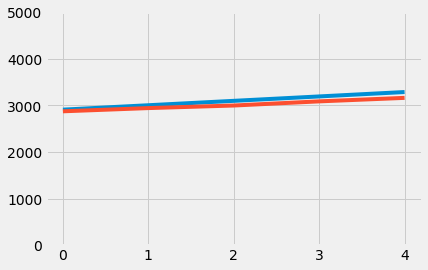

In [501]:
# check against testing data
svm_test_pred = svm_death.predict(X_test_deaths)
plt.ylim([0, 5000])
plt.plot(svm_test_pred)
plt.plot(y_test_deaths)

In [502]:
ensemble_grid =  {'n_estimators': [(i+1)*10 for i in range(20)],
                 'criterion': ['mse', 'mae'],
                 'bootstrap': [True, False],
                 
                 }

ensemble = RandomForestRegressor()
ensemble_search = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
ensemble_search.fit(X_train_deaths, y_train_deaths.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [503]:
ensemble_search.best_params_

{'n_estimators': 60, 'criterion': 'mae', 'bootstrap': False}

In [504]:
ensemble_confirmed = ensemble_search.best_estimator_
ensemble_predd = ensemble_confirmed.predict(future_forcast)

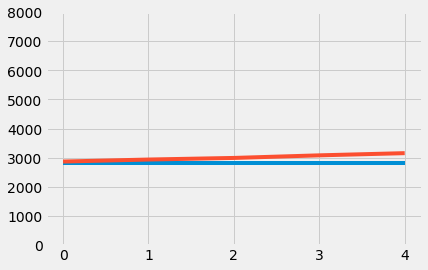

In [505]:
# check against testing data
ensemble_test_pred = ensemble_confirmed.predict(X_test_deaths)
plt.ylim([0, 8000])
plt.plot(ensemble_test_pred)
plt.plot(y_test_deaths)

In [506]:
linear_model = LinearRegression(fit_intercept=False, normalize=True)
linear_model.fit(X_train_deaths, y_train_deaths)
test_linear_pred = linear_model.predict(X_test_deaths)
linear_predd = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_deaths))
print('MSE:',mean_squared_error(test_linear_pred, y_test_deaths))

MAE: 304.9205109218795
MSE: 93046.79079973043


In [507]:
linear_model.coef_

array([[69.38152536]])

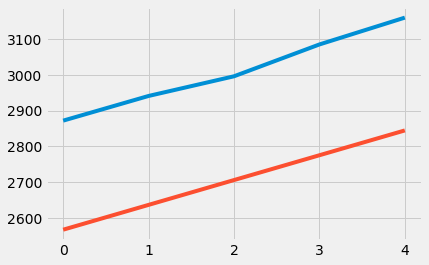

In [508]:
plt.plot(y_test_deaths)
plt.plot(test_linear_pred)

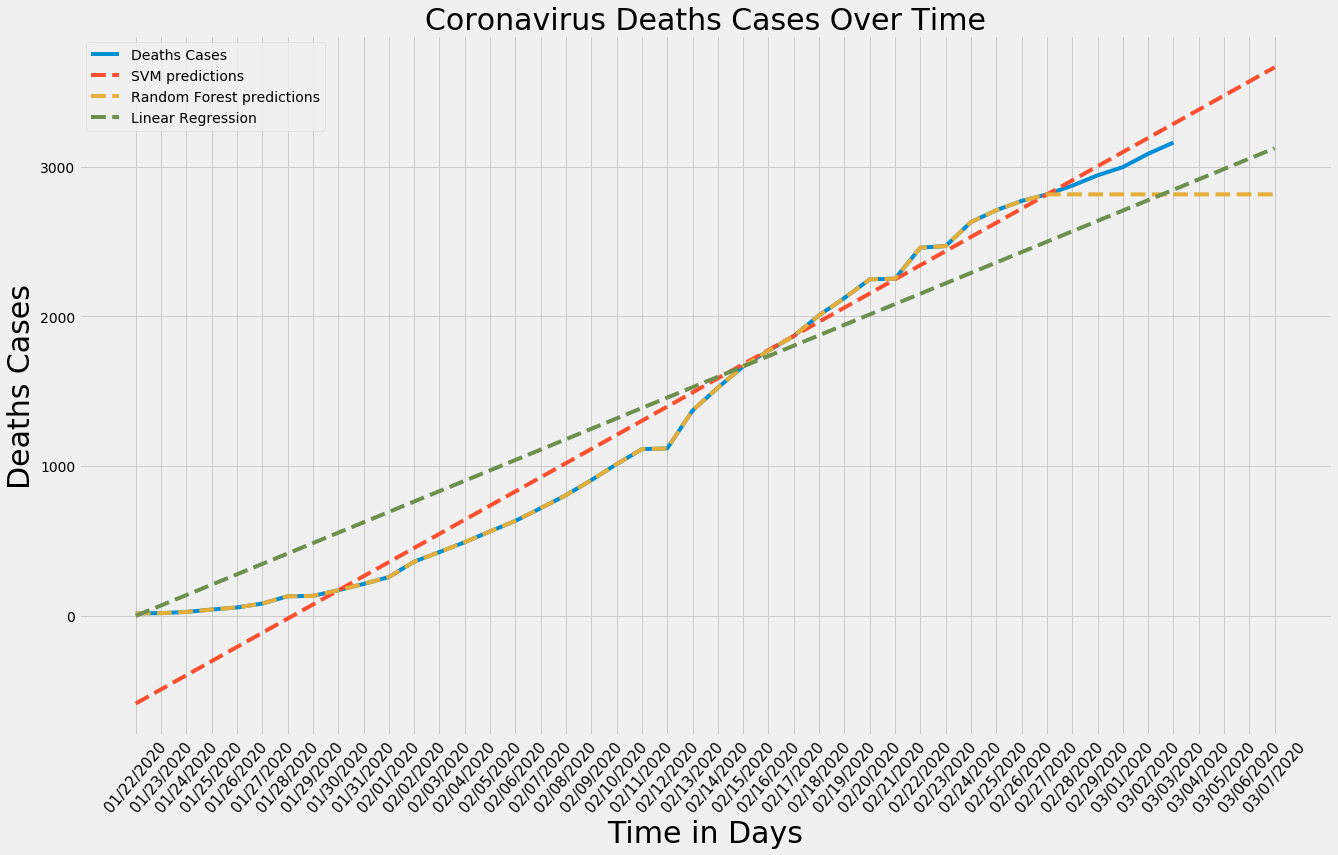

In [509]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths)
plt.plot(future_forcast_dates, svm_predd, linestyle='dashed')
plt.plot(future_forcast_dates, ensemble_predd, linestyle='dashed')
plt.plot(future_forcast_dates, linear_predd, linestyle='dashed')
plt.title('Coronavirus Deaths Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Deaths Cases', size=30)
plt.legend(['Deaths Cases', 'SVM predictions', 'Random Forest predictions', 'Linear Regression'])
plt.xticks(rotation=50, size=15)
plt.show()

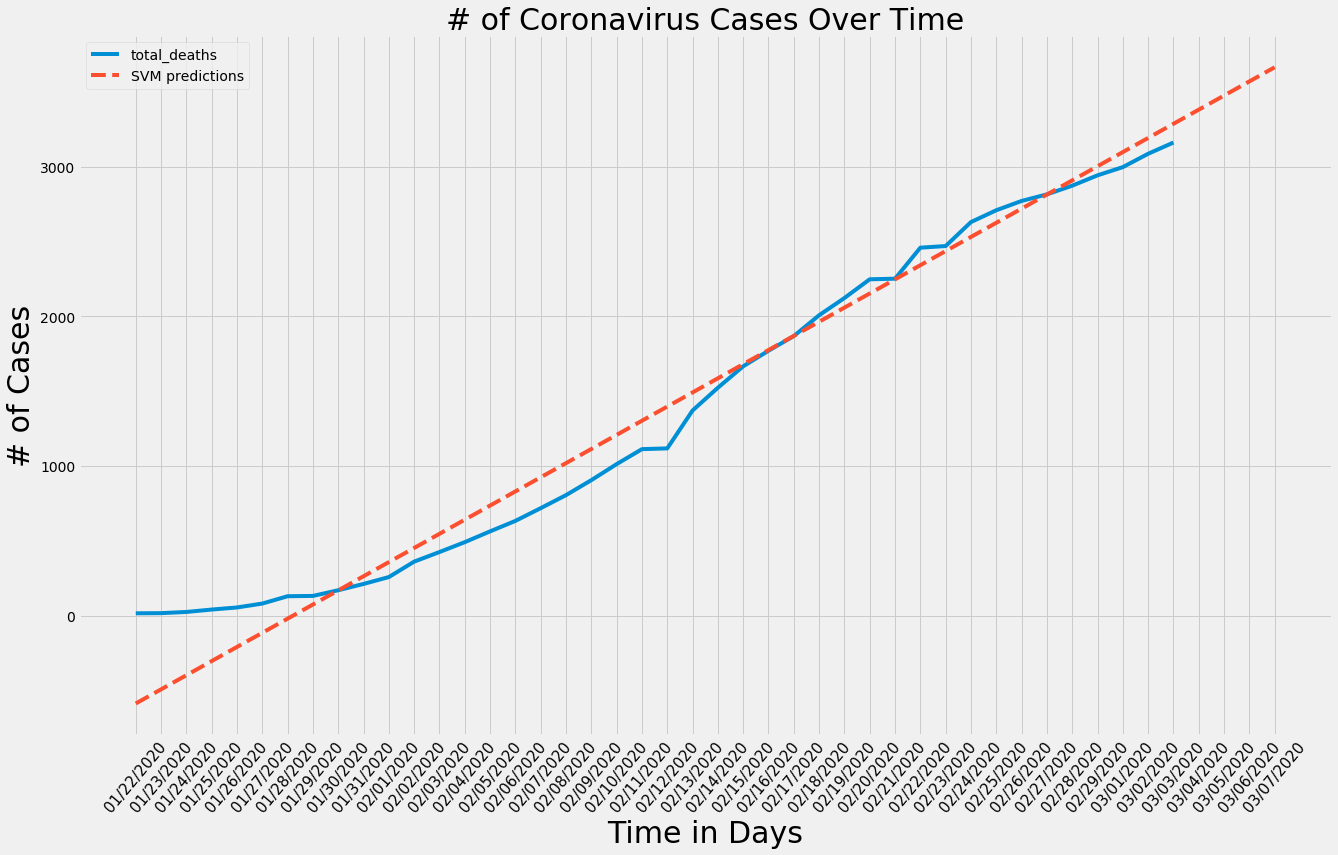

In [530]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths)
plt.plot(future_forcast_dates, svm_predd, linestyle='dashed')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['total_deaths', 'SVM predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

In [532]:
# predictions using svm, which is the best model out of all three 
Deaths_Predict = pd.DataFrame((future_forcast_dates[-4:], svm_predd[-4:]))
Deaths_Predict.columns = Deaths_Predict.iloc[0]
Deaths_Predict = Deaths_Predict.drop([0])
Deaths_Predict.rename({1: 'Deaths'})

,03/04/2020,03/05/2020,03/06/2020,03/07/2020
Deaths,3379.36,3473.75,3568.14,3662.54


In [512]:
cols = recoveries_df.keys()

In [513]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

In [514]:
###Future forecast
days_in_future = 4
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)

In [515]:
X_train_recovered, X_test_recovered, y_train_recovered, y_test_recovered = train_test_split(days_since_1_22, total_recovered, test_size=0.1, shuffle=False) 

In [516]:
kernel = ['linear', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_search.fit(X_train_recovered, y_train_recovered.ravel())

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.0s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [517]:
svm_search.best_params_

{'shrinking': False, 'kernel': 'linear', 'gamma': 0.01, 'epsilon': 1, 'C': 10}

In [533]:
svm_recovered = svm_search.best_estimator_
svm_predr = svm_recovered.predict(future_forcast)

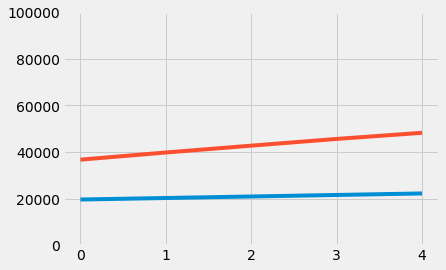

In [534]:
# check against testing data
svm_test_pred = svm_recovered.predict(X_test_recovered)
plt.ylim([0, 1e5])
plt.plot(svm_test_pred)
plt.plot(y_test_recovered)

In [535]:
ensemble_grid =  {'n_estimators': [(i+1)*10 for i in range(20)],
                 'criterion': ['mse', 'mae'],
                 'bootstrap': [True, False],
                 
                 }

ensemble = RandomForestRegressor()
ensemble_search = RandomizedSearchCV(ensemble, ensemble_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
ensemble_search.fit(X_train_recovered, y_train_recovered.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [536]:
ensemble_search.best_params_

{'n_estimators': 30, 'criterion': 'mse', 'bootstrap': False}

In [537]:
ensemble_confirmed = ensemble_search.best_estimator_
ensemble_predr = ensemble_confirmed.predict(future_forcast)

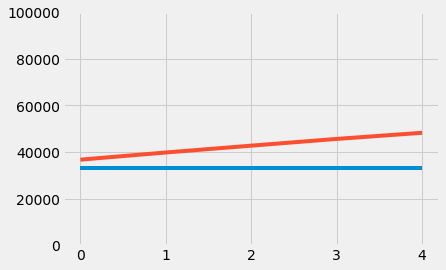

In [538]:
# check against testing data
ensemble_test_pred = ensemble_confirmed.predict(X_test_confirmed)
plt.ylim([0, 1e5])
plt.plot(ensemble_test_pred)
plt.plot(y_test_recovered)

In [539]:
linear_model = LinearRegression(fit_intercept=False, normalize=True)
linear_model.fit(X_train_recovered, y_train_recovered)
test_linear_pred = linear_model.predict(X_test_recovered)
linear_predr = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_recovered))
print('MSE:',mean_squared_error(test_linear_pred, y_test_recovered))

MAE: 20796.767493520918
MSE: 443342302.17882854


In [540]:
linear_model.coef_

array([[559.26237196]])

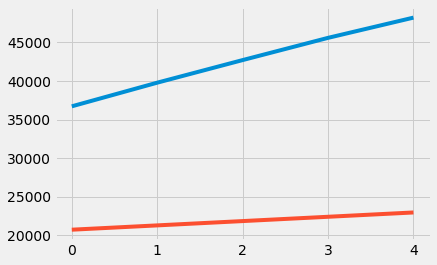

In [541]:
plt.plot(y_test_recovered)
plt.plot(test_linear_pred)

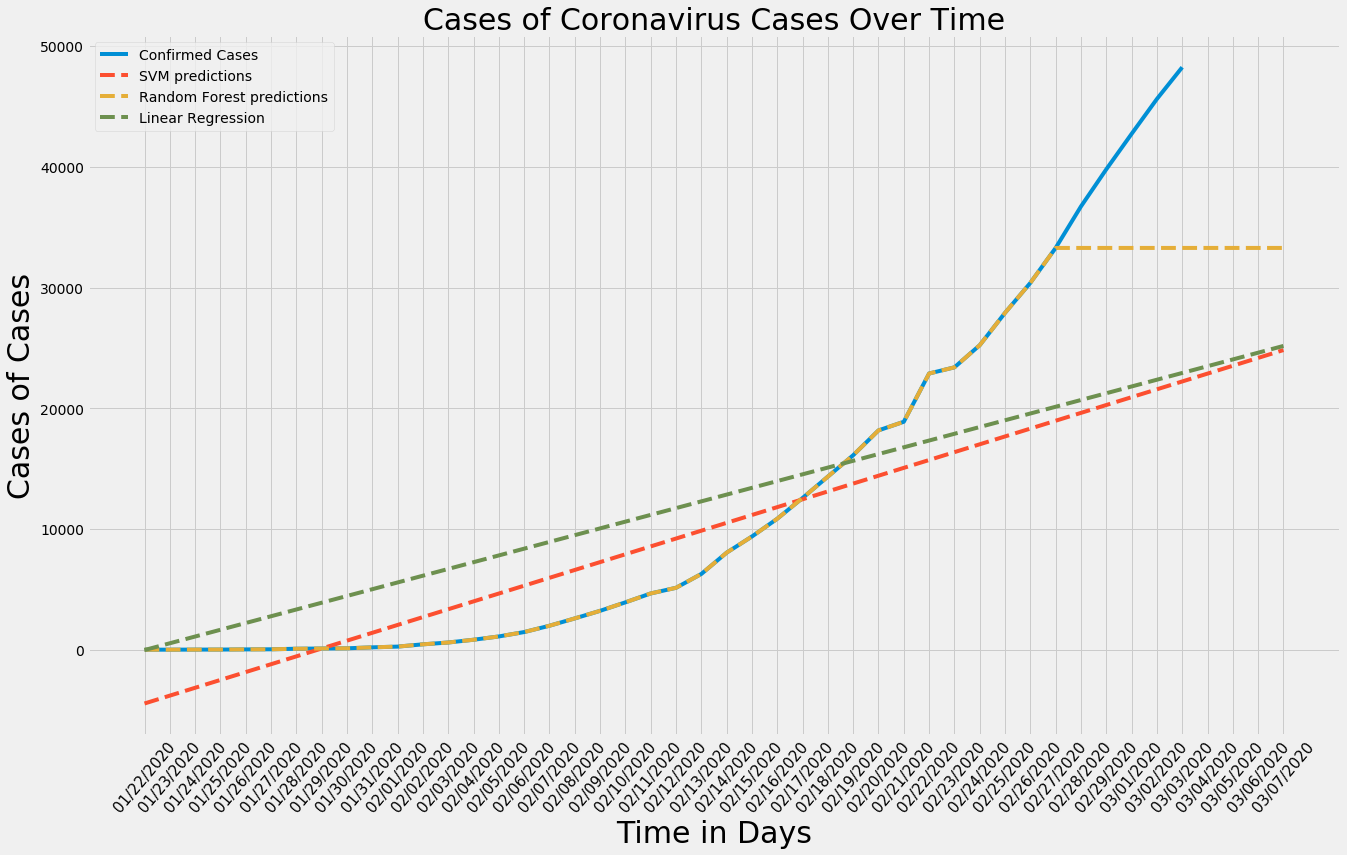

In [542]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_recovered)
plt.plot(future_forcast_dates, svm_predr, linestyle='dashed')
plt.plot(future_forcast_dates, ensemble_predr, linestyle='dashed')
plt.plot(future_forcast_dates, linear_predr, linestyle='dashed')
plt.title('Cases of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('Cases of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions', 'Random Forest predictions', 'Linear Regression'])
plt.xticks(rotation=50, size=15)
plt.show()

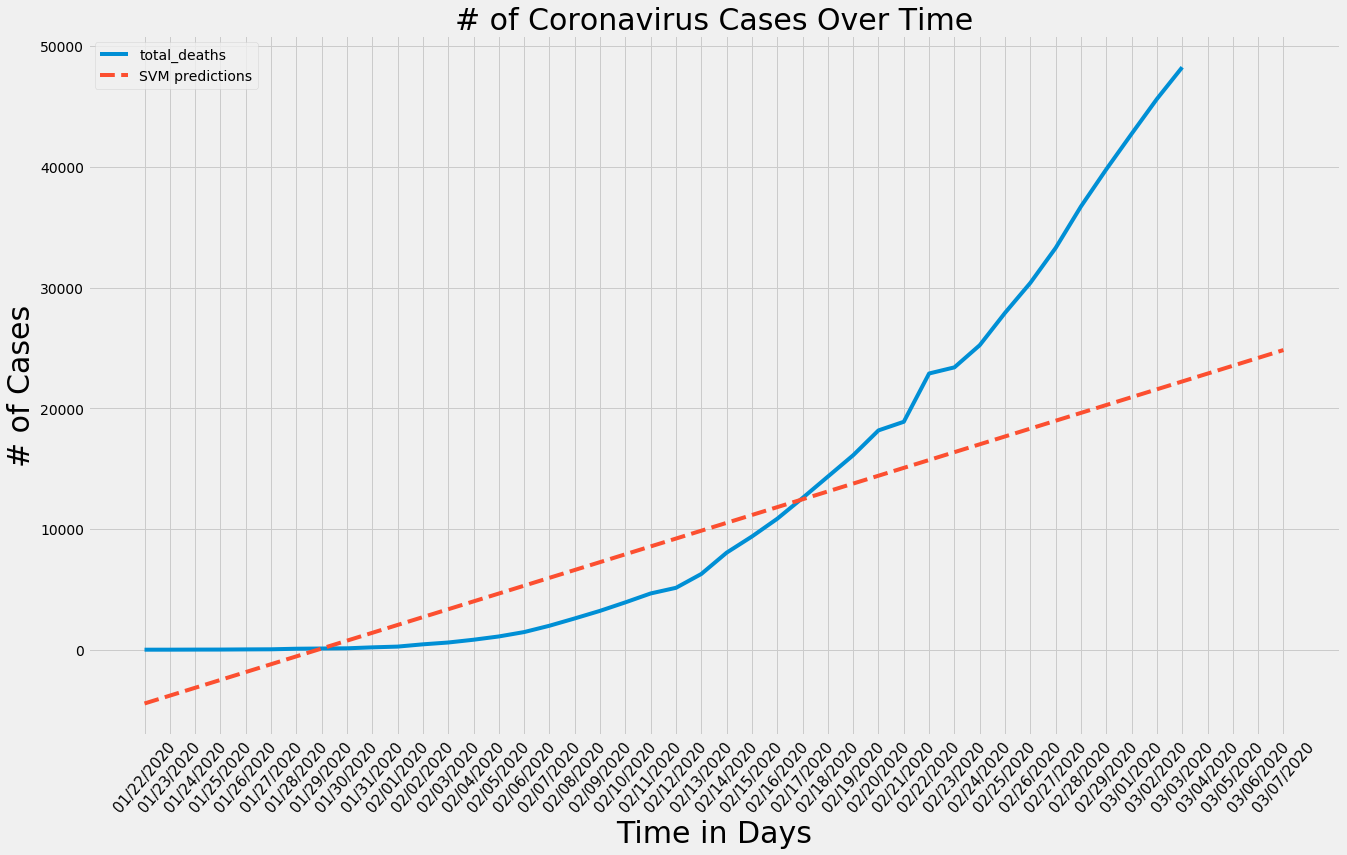

In [543]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_recovered)
plt.plot(future_forcast_dates, svm_pred, linestyle='dashed')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['total_deaths', 'SVM predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

In [545]:
# predictions using svm, which is the best model out of all three 
Deaths_Predict = pd.DataFrame((future_forcast_dates[-4:], svm_predr[-4:]))
Deaths_Predict.columns = Deaths_Predict.iloc[0]
Deaths_Predict = Deaths_Predict.drop([0])
Deaths_Predict.rename({1: 'Deaths'})

,03/04/2020,03/05/2020,03/06/2020,03/07/2020
Deaths,22876,23526,24176,24826
